# Improving What's Cooking Using GNNs to redefine Culinary Boundaries


## Configuration de l'Environnement


In [1]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd

print(f"Version de PyTorch: {torch.__version__}")

Version de PyTorch: 2.2.2+cpu


### Installation de PyTorch Geometric


In [2]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometri

### Import des bibliothèques

In [3]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

---
## Chargement et Exploration des Donnée

Le **FlavorGraph** est un graphe de connaissances culinaires qui contient :
- Des **nœuds** : ingrédients, recettes, composés chimiques
- Des **arêtes** : relations entre ces éléments avec un score de compatibilité

Pour ce projet, on se concentre uniquement sur les relations **ingrédient-ingrédient**.

### Chargement des arêtes (edges)

Chaque arête représente une relation entre deux éléments avec :
- `id_1`, `id_2` : identifiants des nœuds connectés
- `edge_type` : type de relation
- `score` : force de la relation (0-1)

In [4]:
edge_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df = pd.read_csv(edge_url)

print("Distribution des types d'arêtes:")
print(edges_df.edge_type.value_counts())
print(f"\nNombre total d'arêtes: {len(edges_df)}")

edges_df.head()

Distribution des types d'arêtes:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Nombre total d'arêtes: 147179


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Filtrage : uniquement les relations ingrédient-ingrédient

On ne garde que les 111,355 premières lignes qui correspondent aux relations ingrédient-ingrédient (`entity_entity`). Cela simplifie le problème et se concentre sur les paires d'ingrédients.

In [5]:
# Filtrer uniquement les relations entity_entity (ingrédient-ingrédient)
edges_df = edges_df.iloc[:111355, :]

print("Après filtrage:")
print(edges_df.edge_type.value_counts())
print(f"\nAperçu des données:")
edges_df.head()

Après filtrage:
edge_type
ingr-ingr    111355
Name: count, dtype: int64

Aperçu des données:


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Chargement des nœuds (nodes)

Chaque nœud contient :
- `node_id` : identifiant unique
- `name` : nom de l'ingrédient/recette/composé
- `node_type` : type du nœud

In [6]:
node_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df = pd.read_csv(node_url)

print(f"Forme du DataFrame: {nodes_df.shape}")
print("\nAperçu des nœuds:")
nodes_df.head()

Forme du DataFrame: (8298, 5)

Aperçu des nœuds:


,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


### Analyse des types de nœuds

In [7]:
print("Distribution des types de nœuds:")
nodes_df.node_type.value_counts()

Distribution des types de nœuds:


node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

### Filtrage des nœuds pertinents

On ne garde que les nœuds (ingrédients) qui apparaissent dans nos arêtes filtrées.

In [8]:
# Récupérer tous les IDs uniques présents dans les arêtes
relevant_node_ids = set(edges_df.id_1.values).union(set(edges_df.id_2.values))

# Filtrer le DataFrame des nœuds
nodes_df = nodes_df[nodes_df['node_id'].isin(relevant_node_ids)]

print(f"Nombre de nœuds après filtrage: {len(nodes_df)}")
print("\nTypes de nœuds restants:")
nodes_df.node_type.value_counts()

Nombre de nœuds après filtrage: 6653

Types de nœuds restants:


node_type
ingredient    6653
Name: count, dtype: int64

---
## Construction du Graphe

On construit maintenant un objet `Data` de PyTorch Geometric qui représente notre graphe.

### Étapes :
1. Créer un mapping des IDs de nœuds vers des indices contigus (0, 1, 2, ...)
2. Convertir les arêtes en format PyTorch (tenseurs)
3. Créer un graphe non-orienté (undirected)
4. Diviser en ensembles train/validation/test

In [9]:
# Initialisation du graphe
flavorGraph = Data()

# Extraction des poids des arêtes
edge_weight = torch.Tensor(edges_df.score.values)

# Extraction des indices de nœuds
node_index = torch.Tensor(nodes_df.node_id.values)

# Création d'un mapping : node_id -> index continu
node_map = dict()
for i in range(len(node_index)):
    node_map[int(node_index[i])] = i

print(f"Nombre de nœuds: {len(node_map)}")
print(f"Exemple de mapping: {list(node_map.items())[:5]}")

Nombre de nœuds: 6653
Exemple de mapping: [(0, 0), (1, 1), (3, 2), (4, 3), (5, 4)]


### Création de la matrice d'adjacence

Format PyG : `edge_index` est une matrice 2×N où chaque colonne est une arête [source, destination]

In [10]:
# Conversion des IDs d'arêtes vers les indices mappés
edge_index = torch.Tensor([
    edges_df.id_1.apply(lambda x: node_map[x]).values,
    edges_df.id_2.apply(lambda x: node_map[x]).values
])

# Construction du graphe
flavorGraph.x = node_index.view(node_index.size(0), -1)  # Features = node_id
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

# Validation du graphe
flavorGraph.validate(raise_on_error=True)

# Conversion en graphe non-orienté
flavorGraph = ToUndirected()(flavorGraph)
print(f"Graphe non-orienté: {flavorGraph.is_undirected()}")
print(f"\nStatistiques du graphe:")
print(f"  - Nœuds: {flavorGraph.num_nodes}")
print(f"  - Arêtes: {flavorGraph.num_edges}")
print(f"  - Features par nœud: {flavorGraph.num_node_features}")

Graphe non-orienté: True

Statistiques du graphe:
  - Nœuds: 6653
  - Arêtes: 222710
  - Features par nœud: 1


/tmp/ipykernel_82326/3774677864.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.Tensor([


### Division Train/Validation/Test

**RandomLinkSplit** divise les arêtes du graphe en trois ensembles :
- **Train** : pour entraîner le modèle
- **Validation** : pour ajuster les hyperparamètres
- **Test** : pour évaluer les performances finales

Paramètres :
- `is_undirected=True` : graphe non-orienté
- `add_negative_train_samples=False` : on générera les samples négatifs nous-mêmes
- `disjoint_train_ratio=0.35` : 35% des arêtes pour validation/test

In [11]:
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data, val_data, test_data = transform(flavorGraph)

### Aperçu des données d'entraînement

In [12]:
print("Structure de train_data:")
print(train_data)
print("\nStructure de val_data:")
print(val_data)
print("\nStructure de test_data:")
print(test_data)

Structure de train_data:
Data(x=[6653, 1], edge_index=[2, 101334], edge_weight=[101334], edge_label=[27282], edge_label_index=[2, 27282])

Structure de val_data:
Data(x=[6653, 1], edge_index=[2, 155898], edge_weight=[155898], edge_label=[22270], edge_label_index=[2, 22270])

Structure de test_data:
Data(x=[6653, 1], edge_index=[2, 178168], edge_weight=[178168], edge_label=[44542], edge_label_index=[2, 44542])


---
## Modèle GCN (Graph Convolutional Network)

### Architecture du modèle

Le **GCN** fonctionne en deux étapes :

1. **Encodage** : Deux couches de convolution sur graphe qui agrègent les informations des voisins
   - Couche 1 : `num_features → 128 dimensions`
   - Couche 2 : `128 → 64 dimensions` (embeddings finaux)

2. **Décodage** : Prédit la probabilité d'existence d'une arête par produit scalaire des embeddings
   - Si `z[i] · z[j]` est élevé → l'arête (i,j) existe probablement

### Fonctions clés
- `encode()` : transforme le graphe en embeddings
- `decode()` : prédit des arêtes à partir des embeddings
- `decode_all()` : calcule toutes les probabilités d'arêtes possibles

In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Deux couches de convolution sur graphe
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        """Encode le graphe en embeddings de dimension out_channels"""
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        """Prédit la probabilité d'arêtes spécifiques via produit scalaire"""
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        """Calcule la matrice complète de probabilités d'arêtes"""
        prob_adj = z @ z.t()  # Produit matriciel : NxD × DxN = NxN
        prob_adj = torch.sigmoid(prob_adj)  # Conversion en probabilités [0,1]
        return prob_adj

model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Fonctions d'entraînement et d'évaluation

**Entraînement** :
1. Encode le graphe
2. Génère des arêtes négatives (échantillonnage aléatoire)
3. Calcule la loss sur arêtes positives + négatives
4. Backpropagation et mise à jour des poids

**Évaluation** :
- Métrique : **ROC-AUC** (Area Under ROC Curve)
- Mesure la capacité à distinguer arêtes existantes vs. inexistantes

In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    
    # Encodage du graphe
    z = model.encode(train_data.x, train_data.edge_index)

    # Échantillonnage négatif : génère des arêtes qui n'existent pas
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method='sparse'
    )

    # Concaténation arêtes positives + négatives
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Prédiction et calcul de la loss
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    """Évalue le modèle avec la métrique ROC-AUC"""
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)

### Entraînement du modèle GCN

On entraîne pendant **150 epochs** et on sauvegarde :
- Les métriques de validation et test à chaque epoch
- Le meilleur modèle basé sur la validation
- Les probabilités finales pour toutes les paires d'ingrédients

In [15]:
validationMetrics_GCN = []
best_val_auc = 0
final_test_auc = 0

for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    # Sauvegarde du meilleur modèle
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN.append([val_auc, test_auc])
    
    # Affichage tous les 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_GCN = model.decode_all(z)

Epoch: 000, Loss: 3386428.2500, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 163080.1250, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 163080.1250, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 58479.5352, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 58479.5352, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 13974.6357, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 13974.6357, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 5708.5479, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 5708.5479, Val: 0.5000, Test: 0.5000
Epoch: 050, Loss: 1448.6840, Val: 0.5000, Test: 0.5000
Epoch: 050, Loss: 1448.6840, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 697.9639, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 697.9639, Val: 0.5000, Test: 0.5000
Epoch: 070, Loss: 201.0125, Val: 0.5001, Test: 0.5000
Epoch: 070, Loss: 201.0125, Val: 0.5001, Test: 0.5000
Epoch: 080, Loss: 88.6684, Val: 0.5004, Test: 0.5001
Epoch: 080, Loss: 88.6684, Val: 0.5004, Test: 0.5001
Epoch: 090, Loss: 21.6928, Val: 0.5334, Test: 0.5348
Epoch: 09

### Visualisation des performances GCN

Courbe d'évolution du **Test AUC** au fil des epochs.

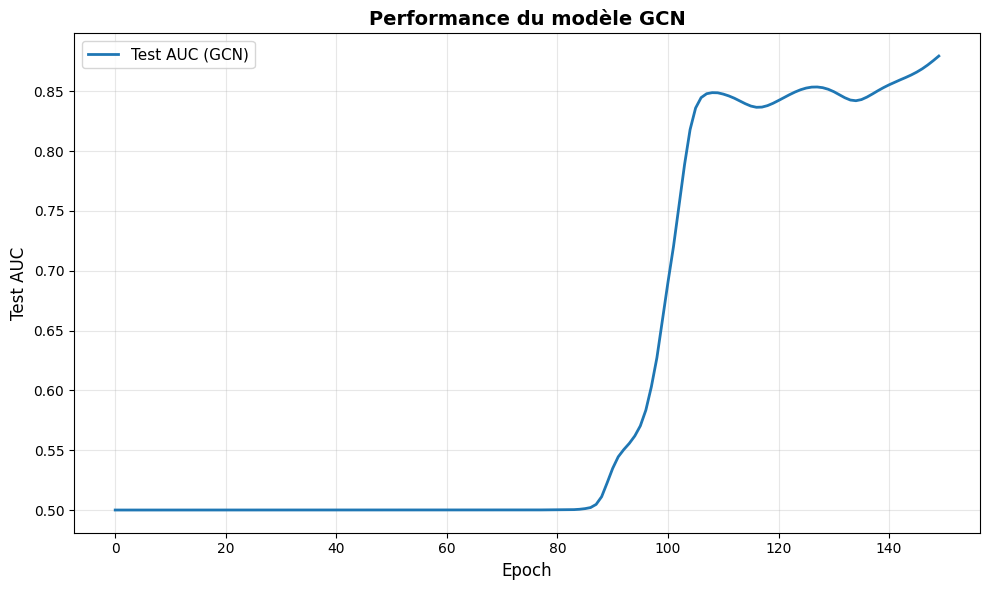

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='Test AUC (GCN)', 
         linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GCN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GCN)

On part d'un ingrédient aléatoire et on suit les liens les plus probables pour créer une "recette" de 2-6 ingrédients.

In [17]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GCN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    # Top 10 ingrédients les plus compatibles
    top_nodes = nodes_df.iloc[final_edge_probs_GCN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GCN:
Ingrédient de départ: diced_fire_roasted_tomato

  1. olive_oil
  2. carrot
  3. olive_oil


---
## Modèle GraphSAGE

### Différences avec GCN

**GraphSAGE** (SAmple and aggreGatE) diffère du GCN par :
1. **Échantillonnage** : ne considère qu'un sous-ensemble de voisins (scalabilité)
2. **Agrégation** : plus flexible (mean, max, LSTM, etc.)

Dans PyG, `SAGEConv` utilise l'agrégation par moyenne.

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Remplacement des couches GCN par SAGEConv
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GraphSAGE

Même architecture que GCN : 1 → 128 → 64

In [19]:
model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GraphSAGE

Même procédure que pour GCN : 150 epochs avec suivi des métriques.

In [20]:
validationMetrics_SAGE = []
best_val_auc = final_test_auc = 0


for epoch in range(0, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_SAGE.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_SAGE = model.decode_all(z)

Epoch: 000, Loss: 89503160.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 35889684.0000, Val: 0.5011, Test: 0.5009
Epoch: 010, Loss: 35889684.0000, Val: 0.5011, Test: 0.5009
Epoch: 020, Loss: 4279437.5000, Val: 0.5047, Test: 0.5036
Epoch: 020, Loss: 4279437.5000, Val: 0.5047, Test: 0.5036
Epoch: 030, Loss: 2703069.7500, Val: 0.5063, Test: 0.5048
Epoch: 030, Loss: 2703069.7500, Val: 0.5063, Test: 0.5048
Epoch: 040, Loss: 1077210.8750, Val: 0.5176, Test: 0.5145
Epoch: 040, Loss: 1077210.8750, Val: 0.5176, Test: 0.5145
Epoch: 050, Loss: 376764.9375, Val: 0.5311, Test: 0.5272
Epoch: 050, Loss: 376764.9375, Val: 0.5311, Test: 0.5272
Epoch: 060, Loss: 235092.1719, Val: 0.5345, Test: 0.5379
Epoch: 060, Loss: 235092.1719, Val: 0.5345, Test: 0.5379
Epoch: 070, Loss: 150513.4531, Val: 0.5368, Test: 0.5373
Epoch: 070, Loss: 150513.4531, Val: 0.5368, Test: 0.5373
Epoch: 080, Loss: 106026.1875, Val: 0.5320, Test: 0.5335
Epoch: 080, Loss: 106026.1875, Val: 0.5320, Test: 0.5335
Epoch: 090, Loss: 7

### Visualisation des performances GraphSAGE

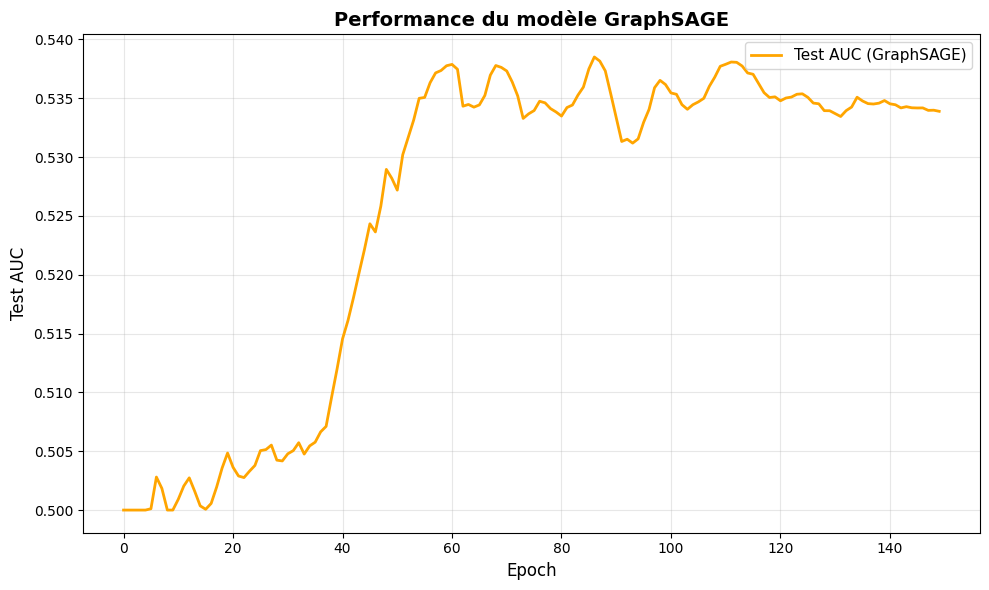

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='Test AUC (GraphSAGE)', 
         linewidth=2,
         color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GraphSAGE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GraphSAGE)

In [22]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GraphSAGE:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_SAGE.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GraphSAGE:
Ingrédient de départ: banana_cake_mix

  1. 2%_buttermilk
  2. 12_inch_pizza_crust
  3. 2%_buttermilk


---
## Comparaison des Modèles

Comparons visuellement les performances de **GCN** et **GraphSAGE** sur l'ensemble de test.

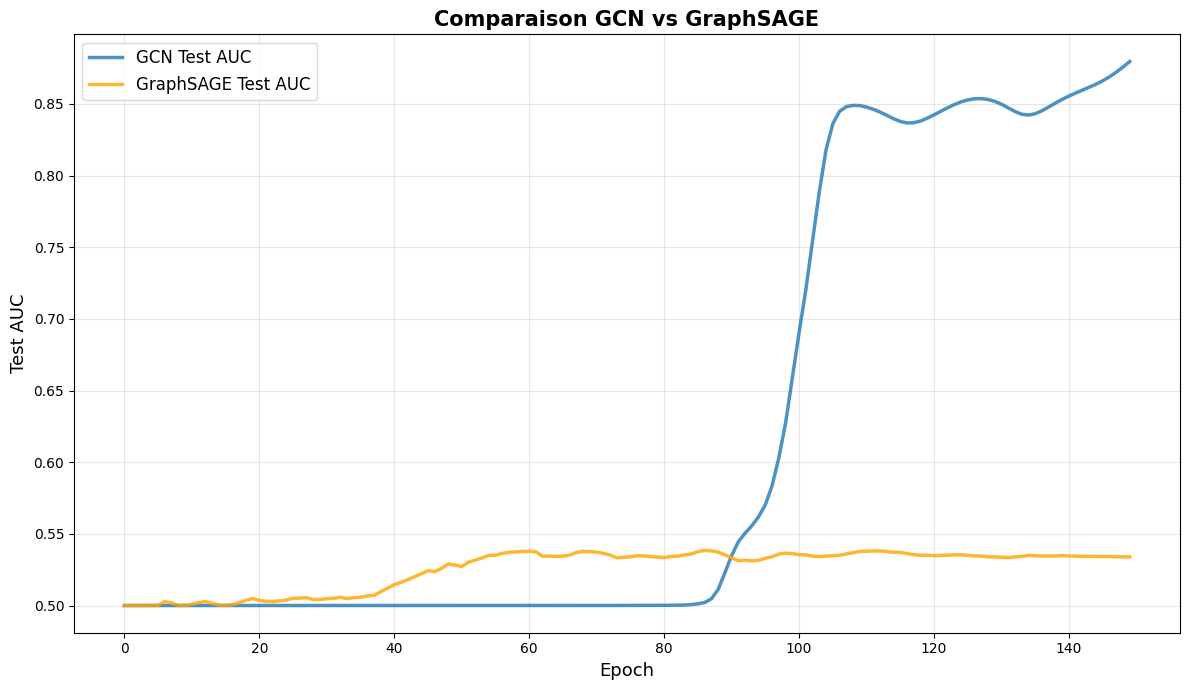


Résultats Finaux:
  GCN Test AUC:        0.8796
  GraphSAGE Test AUC:  0.5339
  Différence:          0.3457

GCN performe mieux de 64.74%


In [23]:
plt.figure(figsize=(12, 7))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison GCN vs GraphSAGE', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]

print("\nRésultats Finaux:")
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  Différence:          {abs(gcn_final - sage_final):.4f}")

if gcn_final > sage_final:
    print(f"\nGCN performe mieux de {((gcn_final - sage_final) / sage_final * 100):.2f}%")
else:
    print(f"\nGraphSAGE performe mieux de {((sage_final - gcn_final) / gcn_final * 100):.2f}%")

---
## Modèle GAT (Graph Attention Network)

### Mécanisme d'attention

**GAT** introduit un mécanisme d'**attention** qui permet au modèle d'apprendre l'importance de chaque voisin :
1. **Poids d'attention** : calcule un score pour chaque voisin
2. **Agrégation pondérée** : combine les informations en fonction de ces scores
3. **Multi-head attention** : utilise plusieurs mécanismes d'attention en parallèle pour capturer différents patterns

Avantages par rapport à GCN :
- Adaptabilité : pondération dynamique des voisins
- Interprétabilité : les poids d'attention révèlent les relations importantes
- Performance : souvent meilleure sur des graphes complexes

In [24]:
# Normalisation des features pour GAT et GIN
train_data_norm = train_data.clone()
val_data_norm = val_data.clone()
test_data_norm = test_data.clone()

mean = train_data.x.mean(dim=0, keepdim=True)
std = train_data.x.std(dim=0, keepdim=True)

train_data_norm.x = (train_data.x - mean) / (std + 1e-10)
val_data_norm.x = (val_data.x - mean) / (std + 1e-10)
test_data_norm.x = (test_data.x - mean) / (std + 1e-10)

print(f'Features normalisées: mean={train_data_norm.x.mean():.4f}, std={train_data_norm.x.std():.4f}')

Features normalisées: mean=-0.0000, std=1.0000


In [25]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        # Couches GAT avec Batch Normalization
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(heads * hidden_channels)
        
        self.conv2 = GATConv(heads * hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GAT

Même architecture de base : 1 → 128 → 64, mais avec mécanisme d'attention multi-têtes.

In [26]:
model = Net(flavorGraph.num_features, 128, 64, heads=4, dropout=0.3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GAT

150 epochs avec mécanisme d'attention pour apprendre les pondérations optimales.

In [27]:
def train_gat():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GAT = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gat()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GAT.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GAT = model.decode_all(z)

Epoch: 000, Loss: 2.4686, Val: 0.3487, Test: 0.3361
Epoch: 010, Loss: 1.0187, Val: 0.3556, Test: 0.3417
Epoch: 010, Loss: 1.0187, Val: 0.3556, Test: 0.3417
Epoch: 020, Loss: 0.8729, Val: 0.3456, Test: 0.3355
Epoch: 020, Loss: 0.8729, Val: 0.3456, Test: 0.3355
Epoch: 030, Loss: 0.8734, Val: 0.3532, Test: 0.3464
Epoch: 030, Loss: 0.8734, Val: 0.3532, Test: 0.3464
Epoch: 040, Loss: 0.8704, Val: 0.5284, Test: 0.5091
Epoch: 040, Loss: 0.8704, Val: 0.5284, Test: 0.5091
Epoch: 050, Loss: 0.8502, Val: 0.6609, Test: 0.6447
Epoch: 050, Loss: 0.8502, Val: 0.6609, Test: 0.6447
Epoch: 060, Loss: 0.8386, Val: 0.7098, Test: 0.7043
Epoch: 060, Loss: 0.8386, Val: 0.7098, Test: 0.7043
Epoch: 070, Loss: 0.8264, Val: 0.6696, Test: 0.6480
Epoch: 070, Loss: 0.8264, Val: 0.6696, Test: 0.6480
Epoch: 080, Loss: 0.7601, Val: 0.5197, Test: 0.4865
Epoch: 080, Loss: 0.7601, Val: 0.5197, Test: 0.4865
Epoch: 090, Loss: 0.7968, Val: 0.3668, Test: 0.3484
Epoch: 090, Loss: 0.7968, Val: 0.3668, Test: 0.3484
Epoch: 100, 

### Visualisation des performances GAT

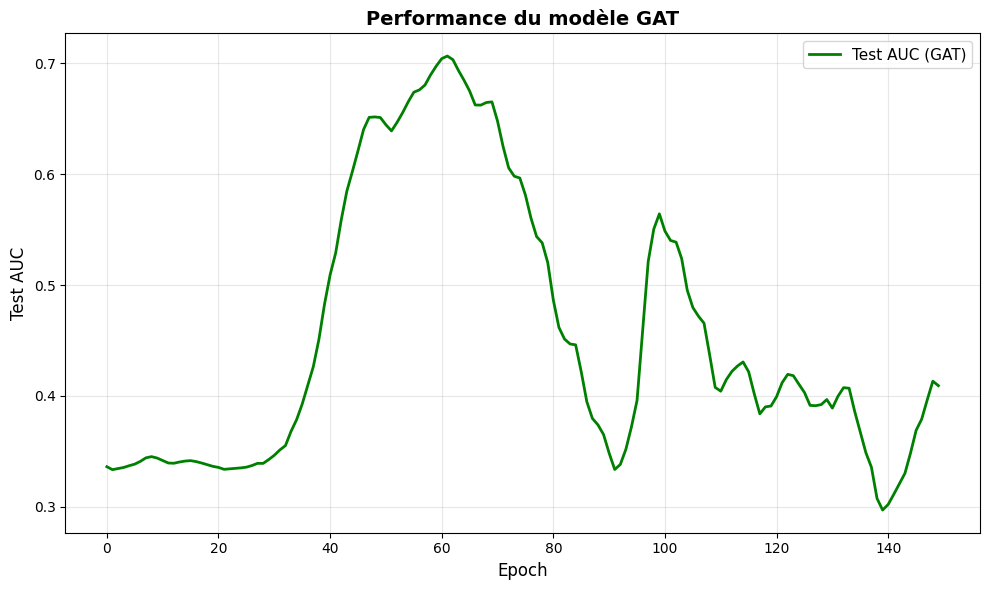

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='Test AUC (GAT)', 
         linewidth=2,
         color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GAT', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GAT)

In [29]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GAT:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GAT.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GAT:
Ingrédient de départ: candied_peel

  1. small_macaroni_noodle
  2. irish_moss
  3. non_alcoholic_beer
  4. prepared_hot_mustard
  5. liquid_dish_soap


---
## Modèle GIN (Graph Isomorphism Network)

### Mécanisme du GIN

**GIN** est basé sur le théorème du Weisfeiler-Lehman (WL) et maximise le pouvoir expressif des GNN :
1. **Agrégation injective** : utilise une fonction qui préserve l'information complète des voisins
2. **MLP** : applique un perceptron multicouche pour transformer les embeddings
3. **Expressivité** : capable de distinguer plus de structures de graphes que GCN ou GraphSAGE

Formule : `h^(k) = MLP^(k)((1 + ε^(k)) · h^(k-1) + SUM(h_j^(k-1)))` où ε est appris.

Avantages :
- Pouvoir discriminatif maximal parmi les GNN par passage de messages
- Capture les motifs structurels complexes
- Théoriquement aussi puissant que le test WL

In [30]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential, Linear, ReLU
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        
        # MLP avec Batch Normalization pour la première couche
        nn1 = Sequential(
            Linear(in_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(hidden_channels, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels)
        )
        self.conv1 = GINConv(nn1, train_eps=False)
        
        # MLP avec Batch Normalization pour la seconde couche
        nn2 = Sequential(
            Linear(hidden_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels),
            ReLU(),
            torch.nn.Dropout(dropout),
            Linear(out_channels, out_channels),
            torch.nn.BatchNorm1d(out_channels)
        )
        self.conv2 = GINConv(nn2, train_eps=False)
        
        # Initialisation Xavier
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

### Initialisation du modèle GIN

Architecture : 1 → 128 → 64 avec MLPs intégrés dans les couches GIN.

In [31]:
model = Net(flavorGraph.num_features, 128, 64, dropout=0.3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
criterion = torch.nn.BCEWithLogitsLoss()

### Entraînement du modèle GIN

150 epochs avec agrégation injective pour maximiser l'expressivité.

In [32]:
def train_gin():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data_norm.x, train_data_norm.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_norm.edge_index, num_nodes=train_data_norm.num_nodes,
                                       num_neg_samples=train_data_norm.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data_norm.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_norm.edge_label, train_data_norm.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

validationMetrics_GIN = []
best_val_auc = final_test_auc = 0

for epoch in range(0, 150):
    loss = train_gin()
    val_auc = test(val_data_norm)
    test_auc = test(test_data_norm)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GIN.append([val_auc, test_auc])
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data_norm.x, test_data_norm.edge_index)
final_edge_probs_GIN = model.decode_all(z)

Epoch: 000, Loss: 8.0379, Val: 0.5808, Test: 0.5647
Epoch: 010, Loss: 5.2728, Val: 0.6915, Test: 0.6691
Epoch: 010, Loss: 5.2728, Val: 0.6915, Test: 0.6691
Epoch: 020, Loss: 4.3998, Val: 0.6668, Test: 0.6462
Epoch: 020, Loss: 4.3998, Val: 0.6668, Test: 0.6462
Epoch: 030, Loss: 3.8005, Val: 0.6533, Test: 0.6298
Epoch: 030, Loss: 3.8005, Val: 0.6533, Test: 0.6298
Epoch: 040, Loss: 3.2910, Val: 0.6471, Test: 0.6239
Epoch: 040, Loss: 3.2910, Val: 0.6471, Test: 0.6239
Epoch: 050, Loss: 2.9059, Val: 0.6575, Test: 0.6362
Epoch: 050, Loss: 2.9059, Val: 0.6575, Test: 0.6362
Epoch: 060, Loss: 2.4693, Val: 0.6487, Test: 0.6327
Epoch: 060, Loss: 2.4693, Val: 0.6487, Test: 0.6327
Epoch: 070, Loss: 2.1203, Val: 0.6537, Test: 0.6424
Epoch: 070, Loss: 2.1203, Val: 0.6537, Test: 0.6424
Epoch: 080, Loss: 1.9986, Val: 0.6378, Test: 0.6437
Epoch: 080, Loss: 1.9986, Val: 0.6378, Test: 0.6437
Epoch: 090, Loss: 1.8404, Val: 0.6138, Test: 0.6325
Epoch: 090, Loss: 1.8404, Val: 0.6138, Test: 0.6325
Epoch: 100, 

### Visualisation des performances GIN

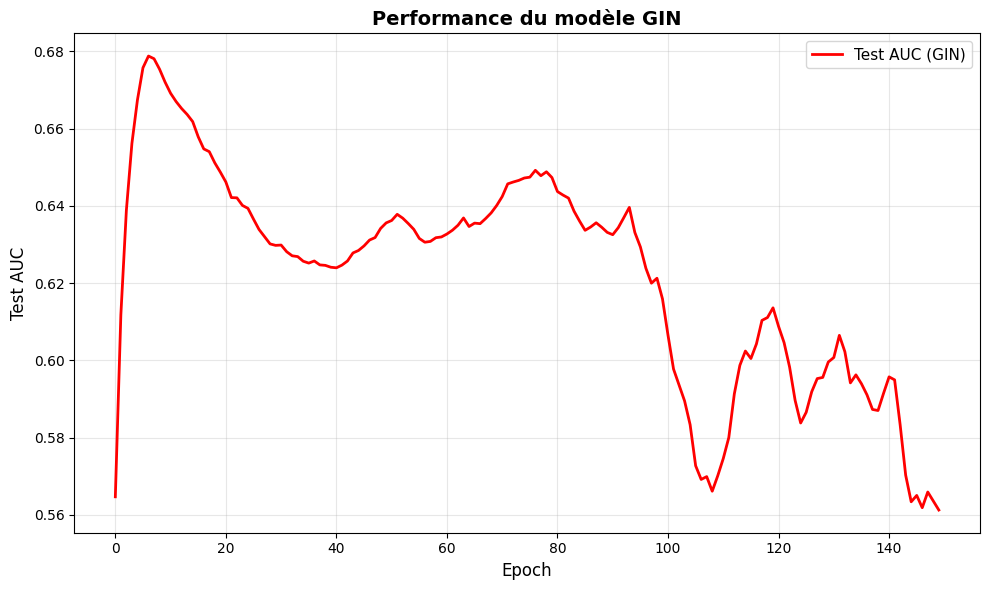

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='Test AUC (GIN)', 
         linewidth=2,
         color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GIN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GIN)

In [34]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GIN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_GIN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

Recette générée avec GIN:
Ingrédient de départ: 85%_lean_ground_beef



---
## Comparaison Complète des 4 Modèles

Comparons maintenant les performances de **GCN**, **GraphSAGE**, **GAT** et **GIN** sur l'ensemble de test.

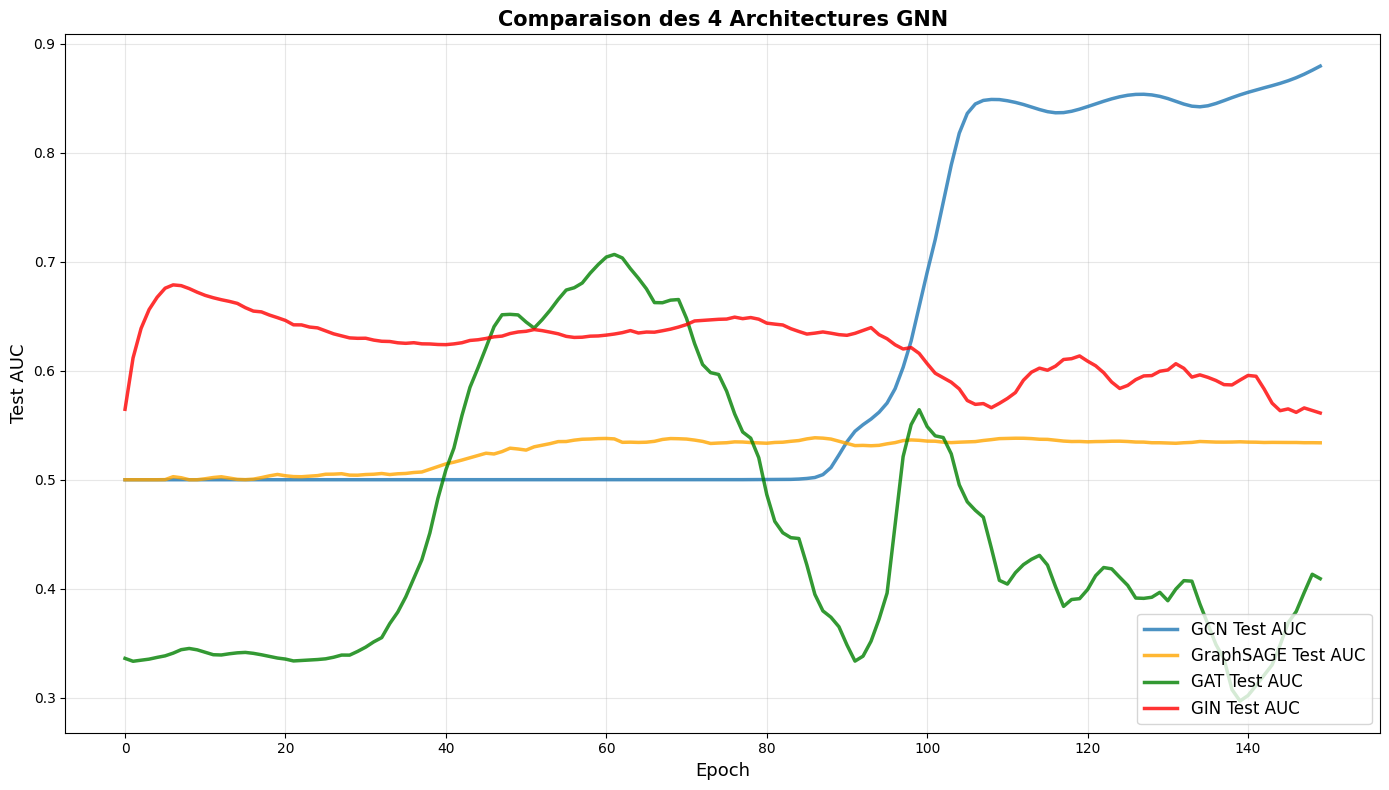


RÉSULTATS FINAUX - Comparaison des Modèles
  GCN Test AUC:        0.8796
  GraphSAGE Test AUC:  0.5339
  GAT Test AUC:        0.4092
  GIN Test AUC:        0.5612


In [35]:
plt.figure(figsize=(14, 8))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.plot(np.arange(len(validationMetrics_GAT)), 
         np.array(validationMetrics_GAT)[:, 1], 
         label='GAT Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='green')

plt.plot(np.arange(len(validationMetrics_GIN)), 
         np.array(validationMetrics_GIN)[:, 1], 
         label='GIN Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='red')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison des 4 Architectures GNN', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]
gat_final = np.array(validationMetrics_GAT)[-1, 1]
gin_final = np.array(validationMetrics_GIN)[-1, 1]

print("\n" + "="*60)
print("RÉSULTATS FINAUX - Comparaison des Modèles")
print("="*60)
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  GAT Test AUC:        {gat_final:.4f}")
print(f"  GIN Test AUC:        {gin_final:.4f}")
print("="*60)

# Déterminer le meilleur modèle
results = {
    'GCN': gcn_final,
    'GraphSAGE': sage_final,
    'GAT': gat_final,
    'GIN': gin_final
}

best_model = max(results, key=results.get)
best_score = results[best_model]

---
## Enrichissement des Features et Métriques Avancées

Dans cette section, nous allons :
1. **Enrichir les features des nœuds** avec des informations sur les composés chimiques, le degré, et des catégories
2. **Ajouter des features d'arêtes** (poids, fréquence, etc.)
3. **Implémenter des métriques avancées** : Precision@K, Recall@K, diversité des prédictions

### Exploration des composés chimiques disponibles

In [36]:
# Rechargeons les données complètes pour explorer les composés chimiques
edges_full = pd.read_csv("https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv")
nodes_full = pd.read_csv("https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv")

print("Types de relations dans le graphe complet:")
print(edges_full.edge_type.value_counts())
print("\nTypes de nœuds dans le graphe complet:")
print(nodes_full.node_type.value_counts())

# Analyser les relations entity-compound (ingrédient-composé chimique)
entity_compound_edges = edges_full[edges_full.edge_type == 'entity_compound']
print(f"\nNombre de relations ingrédient-composé chimique: {len(entity_compound_edges)}")
print("\nAperçu des relations ingrédient-composé:")
entity_compound_edges.head(10)

Types de relations dans le graphe complet:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Types de nœuds dans le graphe complet:
node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

Nombre de relations ingrédient-composé chimique: 0

Aperçu des relations ingrédient-composé:


,id_1,id_2,score,edge_type


### Construction des Features Enrichies

Nous allons créer plusieurs types de features pour chaque ingrédient :

1. **Features structurelles** : degré du nœud, clustering coefficient
2. **Features chimiques** : nombre de composés chimiques liés (si disponible)
3. **Features catégorielles** : catégories d'ingrédients (viandes, légumes, épices, etc.) basées sur des heuristiques simples
4. **Features statistiques** : scores moyens des connexions

In [37]:
from torch_geometric.utils import degree
from collections import defaultdict

# 1. Features structurelles : calcul des degrés
node_degrees = degree(flavorGraph.edge_index[0], num_nodes=flavorGraph.num_nodes)

# 2. Features chimiques : nombre de composés liés à chaque ingrédient
compound_counts = defaultdict(int)
for _, row in entity_compound_edges.iterrows():
    ing_id = row['id_1']
    if ing_id in node_map:
        idx = node_map[ing_id]
        compound_counts[idx] += 1

# Créer un vecteur de comptage de composés
compound_feature = torch.zeros(flavorGraph.num_nodes)
for idx, count in compound_counts.items():
    compound_feature[idx] = count

# 3. Features catégorielles : classification simple par mots-clés
categories_keywords = {
    'meat': ['beef', 'pork', 'chicken', 'lamb', 'turkey', 'duck', 'veal', 'bacon', 'ham', 'sausage', 'meat', 'steak', 'ribs', 'prosciutto'],
    'seafood': ['fish', 'salmon', 'tuna', 'shrimp', 'crab', 'lobster', 'mussel', 'clam', 'oyster', 'cod', 'trout', 'anchovy', 'sardine', 'squid', 'octopus', 'scallop'],
    'vegetable': ['carrot', 'potato', 'tomato', 'onion', 'garlic', 'pepper', 'lettuce', 'cabbage', 'spinach', 'broccoli', 'celery', 'cucumber', 'zucchini', 'eggplant', 'mushroom', 'bean', 'peas', 'corn', 'asparagus', 'artichoke', 'kale', 'leek', 'radish', 'turnip', 'beet', 'cauliflower', 'brussels sprout', 'chard', 'squash', 'pumpkin'],
    'fruit': ['apple', 'banana', 'orange', 'lemon', 'lime', 'strawberry', 'grape', 'cherry', 'peach', 'pear', 'plum', 'mango', 'pineapple', 'melon', 'watermelon', 'kiwi', 'blueberry', 'raspberry', 'blackberry', 'apricot', 'fig', 'date', 'cranberry', 'coconut', 'avocado'],
    'herb_spice': ['basil', 'oregano', 'thyme', 'rosemary', 'cinnamon', 'cumin', 'paprika', 'pepper', 'salt', 'parsley', 'cilantro', 'mint', 'sage', 'dill', 'chive', 'tarragon', 'bay', 'coriander', 'cardamom', 'clove', 'nutmeg', 'ginger', 'turmeric', 'saffron', 'vanilla', 'fennel', 'anise', 'mustard', 'cayenne', 'chili'],
    'dairy': ['milk', 'cheese', 'butter', 'cream', 'yogurt', 'mozzarella', 'parmesan', 'cheddar', 'feta', 'ricotta', 'goat cheese', 'cottage cheese', 'sour cream', 'mascarpone', 'gruyere', 'brie', 'camembert', 'blue cheese'],
    'grain': ['rice', 'wheat', 'flour', 'bread', 'pasta', 'oat', 'barley', 'quinoa', 'couscous', 'bulgur', 'noodle', 'macaroni', 'spaghetti', 'cereal', 'cornmeal', 'semolina', 'rye', 'millet'],
    'legume': ['lentil', 'chickpea', 'bean', 'pinto', 'kidney bean', 'black bean', 'navy bean', 'lima bean', 'fava bean', 'soybean', 'tofu', 'pea', 'split pea', 'edamame', 'lupin'],
    'nut_seed': ['almond', 'walnut', 'pecan', 'cashew', 'pistachio', 'hazelnut', 'macadamia', 'peanut', 'pine nut', 'chestnut', 'sesame', 'sunflower', 'pumpkin seed', 'flax', 'chia'],
    'oil_fat': ['olive oil', 'vegetable oil', 'canola oil', 'sunflower oil', 'sesame oil', 'coconut oil', 'peanut oil', 'avocado oil', 'lard', 'shortening', 'ghee', 'margarine'],
    'sauce_condiment': ['soy sauce', 'vinegar', 'mayonnaise', 'ketchup', 'mustard', 'hot sauce', 'worcestershire', 'barbecue', 'teriyaki', 'hoisin', 'fish sauce', 'tahini', 'pesto', 'salsa', 'chutney', 'relish'],
    'sweetener': ['sugar', 'honey', 'maple syrup', 'molasses', 'agave', 'corn syrup', 'brown sugar', 'powdered sugar', 'stevia'],
    'beverage': ['wine', 'beer', 'sake', 'brandy', 'rum', 'vodka', 'whiskey', 'coffee', 'tea', 'juice', 'broth', 'stock', 'bouillon'],
    'baking': ['baking powder', 'baking soda', 'yeast', 'gelatin', 'cornstarch', 'cocoa', 'chocolate', 'extract', 'food coloring']
}

# Créer des features one-hot pour les catégories
category_features = torch.zeros(flavorGraph.num_nodes, len(categories_keywords))
for idx, node_id in enumerate(flavorGraph.x.squeeze().tolist()):
    # Récupérer le nom de l'ingrédient
    node_row = nodes_df[nodes_df['node_id'] == int(node_id)]
    if len(node_row) > 0:
        node_name = node_row['name'].values[0]
        # Vérifier que le nom n'est pas NaN ou None
        if isinstance(node_name, str):
            node_name = node_name.lower()
            for cat_idx, (cat_name, keywords) in enumerate(categories_keywords.items()):
                if any(keyword in node_name for keyword in keywords):
                    category_features[idx, cat_idx] = 1

# 4. Features statistiques : score moyen des arêtes pour chaque nœud
edge_scores = defaultdict(list)
for _, row in edges_df.iterrows():
    idx1, idx2 = node_map[row['id_1']], node_map[row['id_2']]
    edge_scores[idx1].append(row['score'])
    edge_scores[idx2].append(row['score'])

avg_edge_scores = torch.zeros(flavorGraph.num_nodes)
for idx, scores in edge_scores.items():
    avg_edge_scores[idx] = np.mean(scores)

# Normalisation des features
node_degrees_norm = (node_degrees - node_degrees.mean()) / (node_degrees.std() + 1e-10)
compound_feature_norm = (compound_feature - compound_feature.mean()) / (compound_feature.std() + 1e-10)
avg_edge_scores_norm = (avg_edge_scores - avg_edge_scores.mean()) / (avg_edge_scores.std() + 1e-10)

# Assemblage des features
enriched_features = torch.cat([
    flavorGraph.x,  # ID original
    node_degrees_norm.unsqueeze(1),  # Degré normalisé
    compound_feature_norm.unsqueeze(1),  # Nombre de composés normalisé
    avg_edge_scores_norm.unsqueeze(1),  # Score moyen normalisé
    category_features  # Catégories one-hot
], dim=1)

print(f"Dimensions des features originales: {flavorGraph.x.shape}")
print(f"Dimensions des features enrichies: {enriched_features.shape}")
print(f"\nStatistiques des features:")
print(f"  - Degré moyen: {node_degrees.mean():.2f}")
print(f"  - Ingrédients avec composés chimiques: {(compound_feature > 0).sum()}/{len(compound_feature)}")
print(f"  - Score moyen des arêtes: {avg_edge_scores.mean():.4f}")
print(f"\nDistribution par catégorie:")
for cat_idx, cat_name in enumerate(categories_keywords.keys()):
    count = (category_features[:, cat_idx] == 1).sum()
    print(f"  - {cat_name}: {count} ingrédients")

Dimensions des features originales: torch.Size([6653, 1])
Dimensions des features enrichies: torch.Size([6653, 18])

Statistiques des features:
  - Degré moyen: 33.48
  - Ingrédients avec composés chimiques: 0/6653
  - Score moyen des arêtes: 0.1949

Distribution par catégorie:
  - meat: 738 ingrédients
  - seafood: 206 ingrédients
  - vegetable: 1030 ingrédients
  - fruit: 686 ingrédients
  - herb_spice: 820 ingrédients
  - dairy: 593 ingrédients
  - grain: 588 ingrédients
  - legume: 323 ingrédients
  - nut_seed: 190 ingrédients
  - oil_fat: 27 ingrédients
  - sauce_condiment: 149 ingrédients
  - sweetener: 129 ingrédients
  - beverage: 519 ingrédients
  - baking: 256 ingrédients


### Création du nouveau graphe avec features enrichies

Nous créons maintenant un nouveau graphe avec les features enrichies et le divisons en ensembles train/val/test.

In [38]:
# Créer le nouveau graphe avec features enrichies
flavorGraph_enriched = Data()
flavorGraph_enriched.x = enriched_features.float()
flavorGraph_enriched.edge_index = flavorGraph.edge_index
flavorGraph_enriched.edge_weight = flavorGraph.edge_weight

# Validation
flavorGraph_enriched.validate(raise_on_error=True)
print(f"Graphe enrichi non-orienté: {flavorGraph_enriched.is_undirected()}")
print(f"  - Nœuds: {flavorGraph_enriched.num_nodes}")
print(f"  - Arêtes: {flavorGraph_enriched.num_edges}")
print(f"  - Features par nœud: {flavorGraph_enriched.num_node_features}")

# Division train/val/test
transform_enriched = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data_enriched, val_data_enriched, test_data_enriched = transform_enriched(flavorGraph_enriched)

Graphe enrichi non-orienté: True
  - Nœuds: 6653
  - Arêtes: 222710
  - Features par nœud: 18


### Métriques d'Évaluation Avancées

En plus du ROC-AUC, nous allons implémenter :

1. **Precision@K et Recall@K** : mesure la qualité des top-K prédictions
2. **Hit Rate@K** : proportion de cas où au moins une vraie arête est dans le top-K
3. **Diversité des prédictions** : mesure la variété des catégories dans les prédictions
4. **MRR (Mean Reciprocal Rank)** : position moyenne de la première prédiction correcte

In [65]:
@torch.no_grad()
def compute_advanced_metrics(model, data, k_values=[5, 10, 20], category_features=None):
    """
    Calcule des métriques avancées pour l'évaluation du modèle.
    CORRECTION: Évalue uniquement sur les arêtes de test (positives + négatives)
    
    Args:
        model: Le modèle GNN entraîné
        data: Données de test (Data object)
        k_values: Liste des valeurs de K pour les métriques @K
        category_features: Matrice de features catégorielles pour calculer la diversité
    
    Returns:
        dict: Dictionnaire contenant toutes les métriques
    """
    model.eval()
    z = model.encode(data.x, data.edge_index)
    
    # 1. Calculer les scores pour TOUTES les arêtes de test (pos + neg)
    all_test_scores = model.decode(z, data.edge_label_index).sigmoid()
    test_labels = data.edge_label.cpu().numpy()
    
    # 2. ROC-AUC sur l'ensemble de test complet
    roc_auc = roc_auc_score(test_labels, all_test_scores.cpu().numpy())
    
    # 3. Séparer les arêtes positives et leurs scores
    pos_mask = data.edge_label == 1
    pos_edges = data.edge_label_index[:, pos_mask]
    pos_scores = all_test_scores[pos_mask]
    
    # 4. Séparer les arêtes négatives et leurs scores
    neg_mask = data.edge_label == 0
    neg_edges = data.edge_label_index[:, neg_mask]
    neg_scores = all_test_scores[neg_mask]
    
    num_pos = pos_mask.sum().item()
    num_neg = neg_mask.sum().item()
    
    metrics = {
        'roc_auc': roc_auc,
        'num_test_edges': len(test_labels),
        'num_pos_edges': num_pos,
        'num_neg_edges': num_neg
    }
    
    # 5. Pour chaque K, calculer les métriques
    for k in k_values:
        k_actual = min(k, len(all_test_scores))
        
        # Top-K prédictions parmi TOUTES les arêtes de test
        _, top_k_indices = torch.topk(all_test_scores, k_actual)
        
        # Vérifier combien sont des vrais positifs
        num_correct = (test_labels[top_k_indices.cpu().numpy()] == 1).sum()
        
        # Precision@K
        precision_at_k = num_correct / k_actual
        metrics[f'precision@{k}'] = precision_at_k
        
        # Recall@K
        recall_at_k = num_correct / max(num_pos, 1)
        metrics[f'recall@{k}'] = recall_at_k
        
        # Hit Rate@K
        hit_rate_at_k = 1 if num_correct > 0 else 0
        metrics[f'hit_rate@{k}'] = hit_rate_at_k
        
        # Diversity@K (si features catégorielles disponibles)
        if category_features is not None:
            top_k_categories = []
            for idx in top_k_indices:
                edge_idx = data.edge_label_index[:, idx.item()]
                node1, node2 = edge_idx[0].item(), edge_idx[1].item()
                
                # Catégories des deux nœuds
                if category_features[node1].sum() > 0:
                    cat1 = category_features[node1].argmax().item()
                    top_k_categories.append(cat1)
                if category_features[node2].sum() > 0:
                    cat2 = category_features[node2].argmax().item()
                    top_k_categories.append(cat2)
            
            if len(top_k_categories) > 0:
                unique_categories = len(set(top_k_categories))
                diversity_score = unique_categories / len(categories_keywords)
                metrics[f'diversity@{k}'] = diversity_score
            else:
                metrics[f'diversity@{k}'] = 0.0
    
    # 6. Mean Reciprocal Rank (MRR)
    sorted_indices = torch.argsort(all_test_scores, descending=True)
    sorted_labels = test_labels[sorted_indices.cpu().numpy()]
    
    # Trouver le rang de la première vraie arête positive
    first_pos_rank = np.where(sorted_labels == 1)[0]
    if len(first_pos_rank) > 0:
        mrr = 1.0 / (first_pos_rank[0] + 1)
    else:
        mrr = 0.0
    metrics['mrr'] = mrr
    
    return metrics


def print_metrics(metrics, model_name="Model"):
    """Affiche les métriques de manière formatée."""
    print(f"\n{'='*60}")
    print(f"Métriques d'évaluation pour {model_name}")
    print(f"{'='*60}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Test edges: {metrics['num_test_edges']} (pos: {metrics['num_pos_edges']}, neg: {metrics['num_neg_edges']})")
    print(f"MRR: {metrics['mrr']:.4f}")
    
    for k in [5, 10, 20]:
        if f'precision@{k}' in metrics:
            print(f"\n--- Top-{k} Métriques ---")
            print(f"  Precision@{k}: {metrics[f'precision@{k}']:.4f}")
            print(f"  Recall@{k}: {metrics[f'recall@{k}']:.4f}")
            print(f"  Hit Rate@{k}: {metrics[f'hit_rate@{k}']:.4f}")
            if f'diversity@{k}' in metrics:
                print(f"  Diversity@{k}: {metrics[f'diversity@{k}']:.4f}")
    print(f"{'='*60}")

### Entraînement d'un Modèle GCN avec Features Enrichies

Nous entraînons maintenant un modèle GCN en utilisant les features enrichies pour comparer les performances.

In [40]:
# Modèle GCN avec features enrichies
class EnrichedNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj


# Fonction d'entraînement adaptée
def train_enriched():
    model_enriched.train()
    optimizer_enriched.zero_grad()
    
    z = model_enriched.encode(train_data_enriched.x, train_data_enriched.edge_index)
    
    neg_edge_index = negative_sampling(
        edge_index=train_data_enriched.edge_index,
        num_nodes=train_data_enriched.num_nodes,
        num_neg_samples=train_data_enriched.edge_label_index.size(1),
        method='sparse'
    )

    edge_label_index = torch.cat(
        [train_data_enriched.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data_enriched.edge_label,
        train_data_enriched.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model_enriched.decode(z, edge_label_index).view(-1)
    loss = criterion_enriched(out, edge_label)
    
    loss.backward()
    optimizer_enriched.step()
    return loss


# Fonction d'évaluation pour le modèle enrichi
@torch.no_grad()
def test_enriched(data):
    """Évalue le modèle enrichi avec la métrique ROC-AUC"""
    model_enriched.eval()
    z = model_enriched.encode(data.x, data.edge_index)
    out = model_enriched.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)


# Initialisation du modèle
model_enriched = EnrichedNet(flavorGraph_enriched.num_features, 128, 64)
optimizer_enriched = torch.optim.Adam(params=model_enriched.parameters(), lr=0.01)
criterion_enriched = torch.nn.BCEWithLogitsLoss()

# Entraînement
validationMetrics_GCN_Enriched = []
best_val_auc = final_test_auc = 0

print("Entraînement du modèle GCN avec features enrichies...")
for epoch in range(0, 150):
    loss = train_enriched()
    val_auc = test_enriched(val_data_enriched)
    test_auc = test_enriched(test_data_enriched)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN_Enriched.append([val_auc, test_auc])
    
    if epoch % 30 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nMeilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z_enriched = model_enriched.encode(test_data_enriched.x, test_data_enriched.edge_index)
final_edge_probs_GCN_Enriched = model_enriched.decode_all(z_enriched)

Entraînement du modèle GCN avec features enrichies...
Epoch: 000, Loss: 2757487.7500, Val: 0.5000, Test: 0.5000
Epoch: 000, Loss: 2757487.7500, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 12041.5254, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 12041.5254, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 418.7072, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 418.7072, Val: 0.5000, Test: 0.5000
Epoch: 090, Loss: 17.8475, Val: 0.5392, Test: 0.5422
Epoch: 090, Loss: 17.8475, Val: 0.5392, Test: 0.5422
Epoch: 120, Loss: 0.9453, Val: 0.8659, Test: 0.8628
Epoch: 120, Loss: 0.9453, Val: 0.8659, Test: 0.8628

Meilleur Test AUC: 0.9156

Meilleur Test AUC: 0.9156


### Évaluation avec Métriques Avancées

Comparons maintenant le modèle avec et sans features enrichies en utilisant nos nouvelles métriques.

In [66]:
# Évaluation du modèle GCN enrichi avec métriques avancées
metrics_enriched = compute_advanced_metrics(
    model_enriched, 
    test_data_enriched, 
    k_values=[5, 10, 20],
    category_features=category_features
)

print_metrics(metrics_enriched, "GCN avec Features Enrichies")


Métriques d'évaluation pour GCN avec Features Enrichies
ROC-AUC: 0.9156
Test edges: 44542 (pos: 22271, neg: 22271)
MRR: 1.0000

--- Top-5 Métriques ---
  Precision@5: 1.0000
  Recall@5: 0.0002
  Hit Rate@5: 1.0000
  Diversity@5: 0.3571

--- Top-10 Métriques ---
  Precision@10: 1.0000
  Recall@10: 0.0004
  Hit Rate@10: 1.0000
  Diversity@10: 0.4286

--- Top-20 Métriques ---
  Precision@20: 1.0000
  Recall@20: 0.0009
  Hit Rate@20: 1.0000
  Diversity@20: 0.4286


### Visualisation Comparative

Comparons les performances du modèle de base vs. enrichi.

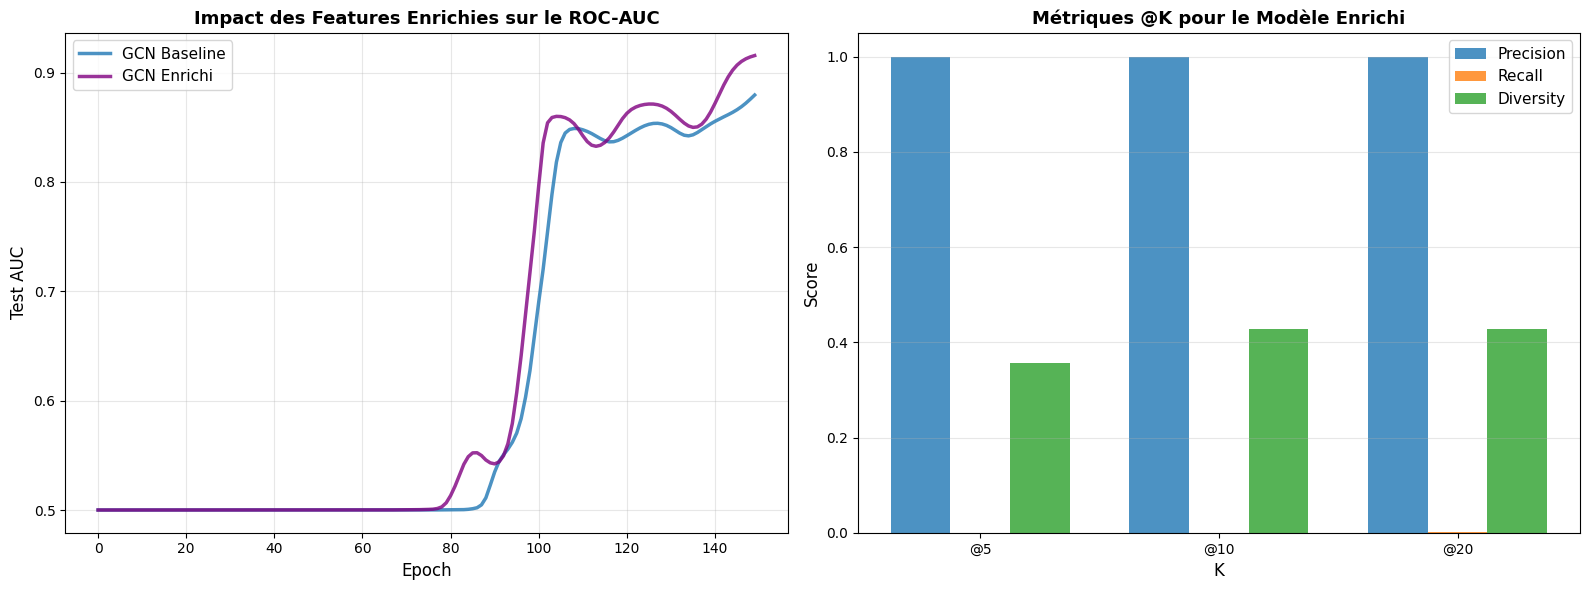


RÉSUMÉ COMPARATIF
Métrique                  GCN Baseline         GCN Enrichi          Amélioration   
--------------------------------------------------------------------------------
ROC-AUC                   0.8796               0.9156                        +4.10%
MRR                       N/A                  1.0000               N/A            
Precision@5               N/A                  1.0000               N/A            
Recall@5                  N/A                  0.0002               N/A            
Diversity@5               N/A                  0.3571               N/A            
Precision@10              N/A                  1.0000               N/A            
Recall@10                 N/A                  0.0004               N/A            
Diversity@10              N/A                  0.4286               N/A            
Precision@20              N/A                  1.0000               N/A            
Recall@20                 N/A                  0.0009       

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vérifier que les données d'entraînement existent
if len(validationMetrics_GCN_Enriched) > 0 and isinstance(validationMetrics_GCN_Enriched[0], (list, tuple)):
    # Graphique 1 : Comparaison ROC-AUC au fil des epochs
    axes[0].plot(np.arange(len(validationMetrics_GCN)), 
                 np.array(validationMetrics_GCN)[:, 1], 
                 label='GCN Baseline', 
                 linewidth=2.5,
                 alpha=0.8)

    axes[0].plot(np.arange(len(validationMetrics_GCN_Enriched)), 
                 np.array(validationMetrics_GCN_Enriched)[:, 1], 
                 label='GCN Enrichi', 
                 linewidth=2.5,
                 alpha=0.8,
                 color='purple')

    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Test AUC', fontsize=12)
    axes[0].set_title('Impact des Features Enrichies sur le ROC-AUC', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Entraînez d\'abord le modèle GCN enrichi\n(exécutez les cellules précédentes)', 
                 ha='center', va='center', fontsize=12, color='red')
    axes[0].set_title('ROC-AUC - En attente d\'entraînement', fontsize=13, fontweight='bold')
    axes[0].axis('off')

# Graphique 2 : Comparaison des métriques @K
if 'metrics_enriched' in locals() and metrics_enriched:
    k_values = [5, 10, 20]
    metrics_to_plot = ['precision', 'recall', 'diversity']

    enriched_values = {metric: [] for metric in metrics_to_plot}

    # Collecter les valeurs pour chaque métrique
    for k in k_values:
        for metric in metrics_to_plot:
            key = f'{metric}@{k}'
            if key in metrics_enriched:
                enriched_values[metric].append(metrics_enriched[key])
            else:
                enriched_values[metric].append(0)

    x = np.arange(len(k_values))
    width = 0.25

    for i, metric in enumerate(metrics_to_plot):
        axes[1].bar(x + i * width, enriched_values[metric], width, 
                    label=f'{metric.capitalize()}', alpha=0.8)

    axes[1].set_xlabel('K', fontsize=12)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title('Métriques @K pour le Modèle Enrichi', fontsize=13, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([f'@{k}' for k in k_values])
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3, axis='y')
else:
    axes[1].text(0.5, 0.5, 'Calculez d\'abord les métriques\n(exécutez les cellules précédentes)', 
                 ha='center', va='center', fontsize=12, color='red')
    axes[1].set_title('Métriques @K - En attente', fontsize=13, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Tableau récapitulatif
if 'metrics_enriched' in locals() and metrics_enriched and len(validationMetrics_GCN_Enriched) > 0:
    print("\n" + "="*80)
    print("RÉSUMÉ COMPARATIF")
    print("="*80)
    print(f"{'Métrique':<25} {'GCN Baseline':<20} {'GCN Enrichi':<20} {'Amélioration':<15}")
    print("-"*80)

    baseline_auc = np.array(validationMetrics_GCN)[-1, 1]
    enriched_auc = metrics_enriched['roc_auc']
    improvement = ((enriched_auc - baseline_auc) / baseline_auc) * 100

    print(f"{'ROC-AUC':<25} {baseline_auc:<20.4f} {enriched_auc:<20.4f} {improvement:>+14.2f}%")
    print(f"{'MRR':<25} {'N/A':<20} {metrics_enriched['mrr']:<20.4f} {'N/A':<15}")

    for k in [5, 10, 20]:
        print(f"{'Precision@' + str(k):<25} {'N/A':<20} {metrics_enriched[f'precision@{k}']:<20.4f} {'N/A':<15}")
        print(f"{'Recall@' + str(k):<25} {'N/A':<20} {metrics_enriched[f'recall@{k}']:<20.4f} {'N/A':<15}")
        print(f"{'Diversity@' + str(k):<25} {'N/A':<20} {metrics_enriched[f'diversity@{k}']:<20.4f} {'N/A':<15}")

    print("="*80)

### Test : Génération de Recettes avec Diversité

Générons une recette en utilisant le modèle enrichi et analysons la diversité des catégories.

In [47]:
def generate_recipe_with_diversity(start_node, model, edge_probs, num_ingredients=5):
    """
    Génère une recette en suivant les liens les plus probables et analyse la diversité.
    
    Args:
        start_node: Index du nœud de départ
        model: Modèle GNN entraîné
        edge_probs: Matrice de probabilités d'arêtes
        num_ingredients: Nombre d'ingrédients à générer
    """
    recipe_nodes = [start_node]
    recipe_names = [nodes_df.iloc[start_node]['name']]
    recipe_categories = []
    
    # Mapper les noms de catégories
    category_names = list(categories_keywords.keys())
    
    # Catégorie de l'ingrédient de départ
    cat_idx = category_features[start_node].argmax().item()
    if category_features[start_node].sum() > 0:
        recipe_categories.append(category_names[cat_idx])
    else:
        recipe_categories.append('unknown')
    
    current_node = start_node
    
    for i in range(1, num_ingredients):
        # Top 10 ingrédients les plus compatibles
        top_nodes_idx = edge_probs.topk(10, dim=1).indices[current_node]
        
        # Choisir aléatoirement parmi les top 10
        which_one = np.random.randint(0, 10)
        next_node_idx = top_nodes_idx[which_one].item()
        
        # Obtenir le nom et la catégorie
        next_node_id = int(flavorGraph.x[next_node_idx].item())
        next_node_info = nodes_df[nodes_df['node_id'] == next_node_id].iloc[0]
        
        recipe_nodes.append(next_node_idx)
        recipe_names.append(next_node_info['name'])
        
        cat_idx = category_features[next_node_idx].argmax().item()
        if category_features[next_node_idx].sum() > 0:
            recipe_categories.append(category_names[cat_idx])
        else:
            recipe_categories.append('unknown')
        
        current_node = next_node_idx
    
    # Calculer la diversité
    unique_categories = len(set(recipe_categories))
    diversity_score = unique_categories / len(recipe_categories)
    
    return recipe_names, recipe_categories, diversity_score


# Générer plusieurs recettes et analyser la diversité
print("="*70)
print("GÉNÉRATION DE RECETTES AVEC ANALYSE DE DIVERSITÉ")
print("="*70)

for recipe_num in range(3):
    start_node = np.random.randint(0, len(nodes_df))
    recipe_names, recipe_categories, diversity = generate_recipe_with_diversity(
        start_node, 
        model_enriched, 
        final_edge_probs_GCN_Enriched,
        num_ingredients=6
    )
    
    print(f"\nRecette #{recipe_num + 1}:")
    print("-" * 70)
    for i, (name, cat) in enumerate(zip(recipe_names, recipe_categories)):
        print(f"  {i+1}. {name:<30} [{cat}]")
    print(f"\nScore de diversité: {diversity:.2%} ({len(set(recipe_categories))}/{len(recipe_categories)} catégories uniques)")
    
print("\n" + "="*70)

GÉNÉRATION DE RECETTES AVEC ANALYSE DE DIVERSITÉ

Recette #1:
----------------------------------------------------------------------
  1. ground_sausage                 [meat]
  2. butter                         [dairy]
  3. water                          [unknown]
  4. sugar                          [sweetener]
  5. milk                           [dairy]
  6. sugar                          [sweetener]

Score de diversité: 66.67% (4/6 catégories uniques)

Recette #2:
----------------------------------------------------------------------
  1. unsalted_margarine             [herb_spice]
  2. milk                           [dairy]
  3. egg                            [unknown]
  4. sugar                          [sweetener]
  5. salt                           [herb_spice]
  6. olive_oil                      [unknown]

Score de diversité: 66.67% (4/6 catégories uniques)

Recette #3:
----------------------------------------------------------------------
  1. fresh_sage                     [h

### Entraînement de GAT avec Features Enrichies

Entraînons maintenant le modèle GAT avec les features enrichies pour comparer les architectures.

In [ ]:
from torch_geometric.nn import GATConv

class EnrichedGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(heads * hidden_channels)
        
        self.conv2 = GATConv(heads * hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj


def train_gat_enriched():
    model_gat_enriched.train()
    optimizer_gat_enriched.zero_grad()
    z = model_gat_enriched.encode(train_data_enriched.x, train_data_enriched.edge_index)
    neg_edge_index = negative_sampling(edge_index=train_data_enriched.edge_index, 
                                       num_nodes=train_data_enriched.num_nodes,
                                       num_neg_samples=train_data_enriched.edge_label_index.size(1), 
                                       method='sparse')
    edge_label_index = torch.cat([train_data_enriched.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data_enriched.edge_label, 
                           train_data_enriched.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
    out = model_gat_enriched.decode(z, edge_label_index).view(-1)
    loss = criterion_gat_enriched(out, edge_label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_gat_enriched.parameters(), max_norm=1.0)
    optimizer_gat_enriched.step()
    return loss


# Fonction d'évaluation pour GAT enrichi
@torch.no_grad()
def test_gat_enriched(data):
    """Évalue le modèle GAT enrichi avec la métrique ROC-AUC"""
    model_gat_enriched.eval()
    z = model_gat_enriched.encode(data.x, data.edge_index)
    out = model_gat_enriched.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)


# Initialisation
model_gat_enriched = EnrichedGAT(flavorGraph_enriched.num_features, 128, 64, heads=4, dropout=0.3)
optimizer_gat_enriched = torch.optim.Adam(params=model_gat_enriched.parameters(), lr=0.001)
criterion_gat_enriched = torch.nn.BCEWithLogitsLoss()

# Entraînement
validationMetrics_GAT_Enriched = []
best_val_auc = final_test_auc = 0

print("Entraînement du modèle GAT avec features enrichies...")
for epoch in range(0, 150):
    loss = train_gat_enriched()
    val_auc = test_gat_enriched(val_data_enriched)
    test_auc = test_gat_enriched(test_data_enriched)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GAT_Enriched.append([val_auc, test_auc])
    
    if epoch % 30 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nMeilleur Test AUC (GAT Enrichi): {final_test_auc:.4f}')

Entraînement du modèle GAT avec features enrichies...
Epoch: 000, Loss: 5.2066, Val: 0.5002, Test: 0.5003
Epoch: 000, Loss: 5.2066, Val: 0.5002, Test: 0.5003
Epoch: 030, Loss: 1.0684, Val: 0.2963, Test: 0.2968
Epoch: 030, Loss: 1.0684, Val: 0.2963, Test: 0.2968
Epoch: 060, Loss: 0.7842, Val: 0.3771, Test: 0.3842
Epoch: 060, Loss: 0.7842, Val: 0.3771, Test: 0.3842
Epoch: 090, Loss: 0.8522, Val: 0.3363, Test: 0.3460
Epoch: 090, Loss: 0.8522, Val: 0.3363, Test: 0.3460
Epoch: 120, Loss: 0.7455, Val: 0.3499, Test: 0.3462
Epoch: 120, Loss: 0.7455, Val: 0.3499, Test: 0.3462

Meilleur Test AUC (GAT Enrichi): 0.6579

Meilleur Test AUC (GAT Enrichi): 0.6579

Métriques d'évaluation pour GAT avec Features Enrichies
ROC-AUC: 0.3873

--- Top-5 Métriques ---
  Precision@5: 0.0000
  Recall@5: 0.0000
  Hit Rate@5: 0.0000
  Diversity@5: 0.2857

--- Top-10 Métriques ---
  Precision@10: 0.0000
  Recall@10: 0.0000
  Hit Rate@10: 0.0000
  Diversity@10: 0.4286

Métriques d'évaluation pour GAT avec Features E

In [67]:
# Métriques avancées pour GAT enrichi
metrics_gat_enriched = compute_advanced_metrics(
    model_gat_enriched, 
    test_data_enriched, 
    k_values=[5, 10, 20],
    category_features=category_features
)

print_metrics(metrics_gat_enriched, "GAT avec Features Enrichies")


Métriques d'évaluation pour GAT avec Features Enrichies
ROC-AUC: 0.3873
Test edges: 44542 (pos: 22271, neg: 22271)
MRR: 0.2000

--- Top-5 Métriques ---
  Precision@5: 0.2000
  Recall@5: 0.0000
  Hit Rate@5: 1.0000
  Diversity@5: 0.2857

--- Top-10 Métriques ---
  Precision@10: 0.4000
  Recall@10: 0.0002
  Hit Rate@10: 1.0000
  Diversity@10: 0.5714

--- Top-20 Métriques ---
  Precision@20: 0.6000
  Recall@20: 0.0005
  Hit Rate@20: 1.0000
  Diversity@20: 0.6429


### Comparaison Finale : Tous les Modèles

Visualisons maintenant les performances de tous les modèles (baseline et enrichis) avec les métriques avancées.

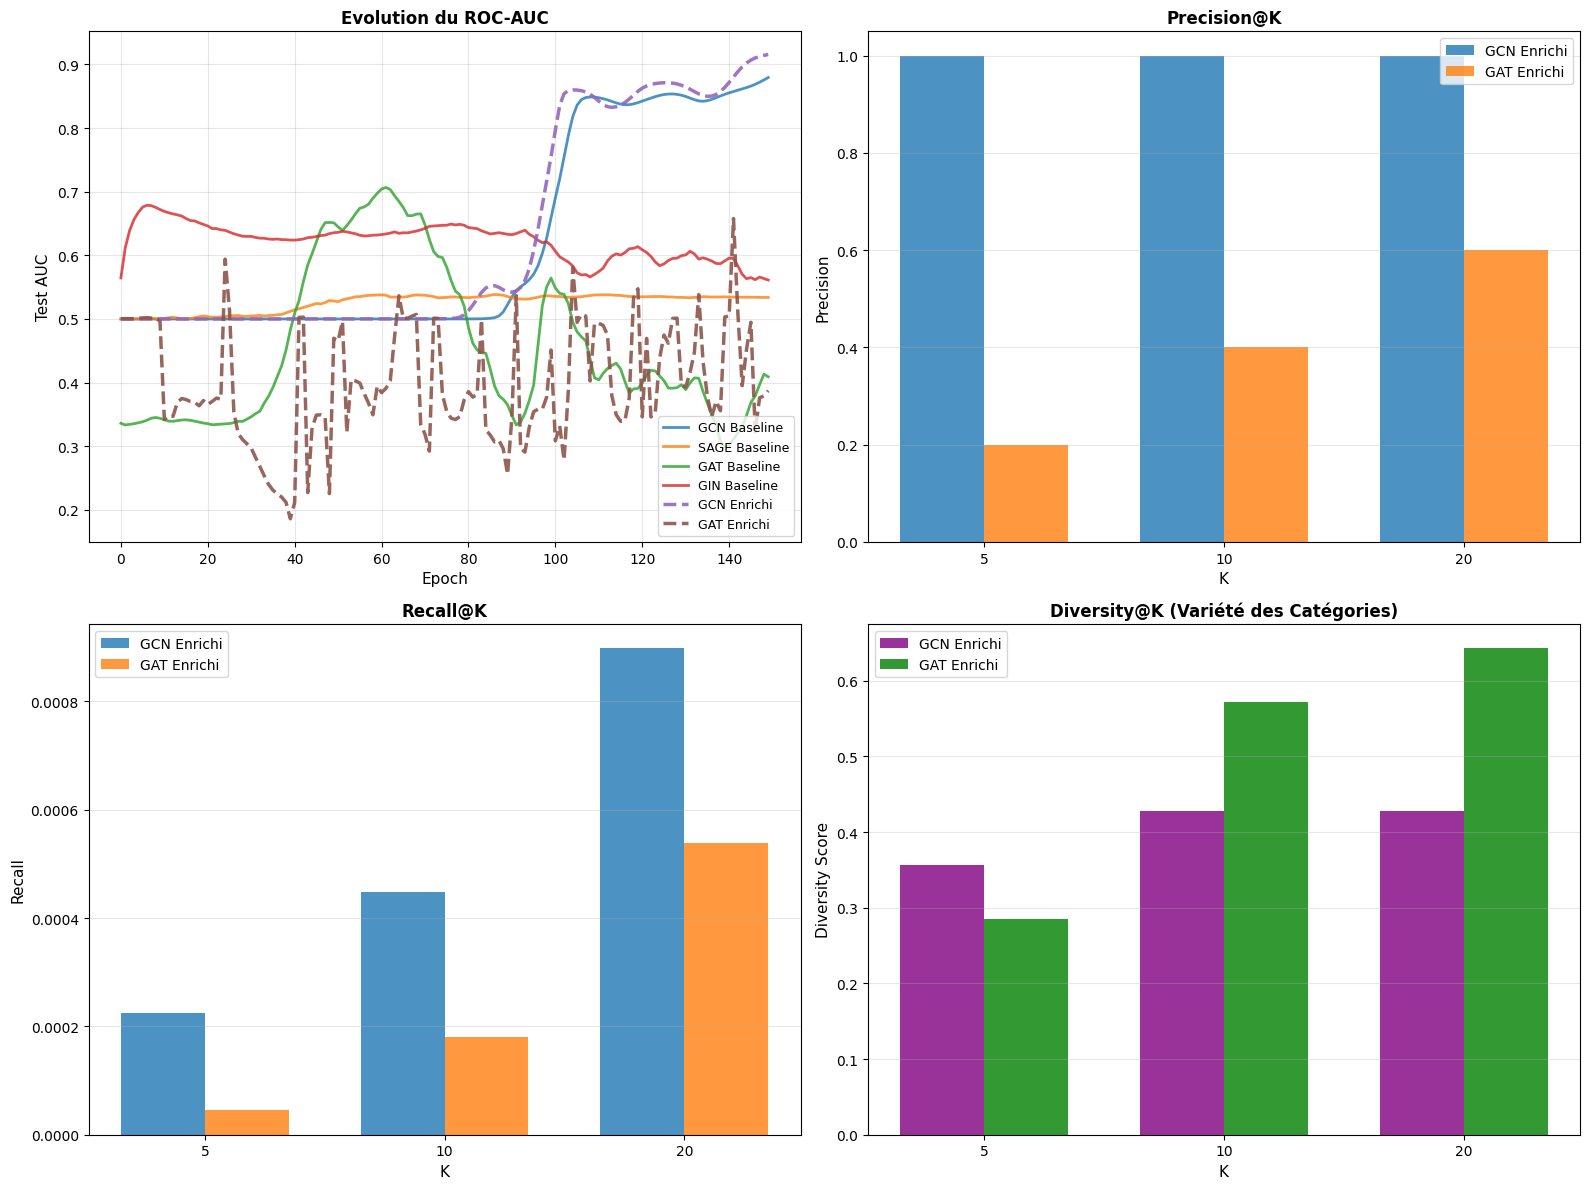


TABLEAU RÉCAPITULATIF FINAL - COMPARAISON DE TOUS LES MODÈLES
Modèle               ROC-AUC      MRR          P@10         R@10         Div@10      
----------------------------------------------------------------------------------------------------
GCN Baseline         0.8796       N/A          N/A          N/A          N/A         
SAGE Baseline        0.5339       N/A          N/A          N/A          N/A         
GAT Baseline         0.4092       N/A          N/A          N/A          N/A         
GIN Baseline         0.5612       N/A          N/A          N/A          N/A         
GCN Enrichi          0.9156       N/A          1.0000       0.0004       0.4286      
GAT Enrichi          0.3873       N/A          0.4000       0.0002       0.5714      

CONCLUSIONS
1. Impact des features enrichies:
   - Amélioration du ROC-AUC: +4.10%
   - Les features enrichies (degré, composés chimiques, catégories) apportent des informations utiles

2. Métriques de recommandation:
   - Precision@

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1 : Evolution du Test AUC
axes[0, 0].plot(np.arange(len(validationMetrics_GCN)), 
                np.array(validationMetrics_GCN)[:, 1], 
                label='GCN Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_SAGE)), 
                np.array(validationMetrics_SAGE)[:, 1], 
                label='SAGE Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GAT)), 
                np.array(validationMetrics_GAT)[:, 1], 
                label='GAT Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GIN)), 
                np.array(validationMetrics_GIN)[:, 1], 
                label='GIN Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(np.arange(len(validationMetrics_GCN_Enriched)), 
                np.array(validationMetrics_GCN_Enriched)[:, 1], 
                label='GCN Enrichi', linewidth=2.5, alpha=0.9, linestyle='--')
axes[0, 0].plot(np.arange(len(validationMetrics_GAT_Enriched)), 
                np.array(validationMetrics_GAT_Enriched)[:, 1], 
                label='GAT Enrichi', linewidth=2.5, alpha=0.9, linestyle='--')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Test AUC', fontsize=11)
axes[0, 0].set_title('Evolution du ROC-AUC', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9, loc='lower right')
axes[0, 0].grid(alpha=0.3)

# Graphique 2 : Comparaison Precision@K
k_values = [5, 10, 20]
gcn_enriched_precision = [metrics_enriched[f'precision@{k}'] for k in k_values]
gat_enriched_precision = [metrics_gat_enriched[f'precision@{k}'] for k in k_values]

x = np.arange(len(k_values))
width = 0.35

axes[0, 1].bar(x - width/2, gcn_enriched_precision, width, label='GCN Enrichi', alpha=0.8)
axes[0, 1].bar(x + width/2, gat_enriched_precision, width, label='GAT Enrichi', alpha=0.8)
axes[0, 1].set_xlabel('K', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision@K', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'{k}' for k in k_values])
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Graphique 3 : Comparaison Recall@K
gcn_enriched_recall = [metrics_enriched[f'recall@{k}'] for k in k_values]
gat_enriched_recall = [metrics_gat_enriched[f'recall@{k}'] for k in k_values]

axes[1, 0].bar(x - width/2, gcn_enriched_recall, width, label='GCN Enrichi', alpha=0.8)
axes[1, 0].bar(x + width/2, gat_enriched_recall, width, label='GAT Enrichi', alpha=0.8)
axes[1, 0].set_xlabel('K', fontsize=11)
axes[1, 0].set_ylabel('Recall', fontsize=11)
axes[1, 0].set_title('Recall@K', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'{k}' for k in k_values])
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')

# Graphique 4 : Comparaison Diversité@K
gcn_enriched_diversity = [metrics_enriched[f'diversity@{k}'] for k in k_values]
gat_enriched_diversity = [metrics_gat_enriched[f'diversity@{k}'] for k in k_values]

axes[1, 1].bar(x - width/2, gcn_enriched_diversity, width, label='GCN Enrichi', alpha=0.8, color='purple')
axes[1, 1].bar(x + width/2, gat_enriched_diversity, width, label='GAT Enrichi', alpha=0.8, color='green')
axes[1, 1].set_xlabel('K', fontsize=11)
axes[1, 1].set_ylabel('Diversity Score', fontsize=11)
axes[1, 1].set_title('Diversity@K (Variété des Catégories)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'{k}' for k in k_values])
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tableau récapitulatif final
print("\n" + "="*100)
print("TABLEAU RÉCAPITULATIF FINAL - COMPARAISON DE TOUS LES MODÈLES")
print("="*100)
print(f"{'Modèle':<20} {'ROC-AUC':<12} {'MRR':<12} {'P@10':<12} {'R@10':<12} {'Div@10':<12}")
print("-"*100)

for model_name, auc, mrr, p10, r10, d10 in models_summary:
    auc_str = f"{auc:.4f}" if isinstance(auc, float) else auc
    mrr_str = f"{mrr:.4f}" if isinstance(mrr, float) else mrr
    p10_str = f"{p10:.4f}" if isinstance(p10, float) else p10
    r10_str = f"{r10:.4f}" if isinstance(r10, float) else r10
    d10_str = f"{d10:.4f}" if isinstance(d10, float) else d10
    print(f"{model_name:<20} {auc_str:<12} {mrr_str:<12} {p10_str:<12} {r10_str:<12} {d10_str:<12}")

print("="*100)

# Déterminer le meilleur modèle
print("\n" + "="*100)
print("CONCLUSIONS")
print("="*100)
print("1. Impact des features enrichies:")
baseline_best = max(np.array(validationMetrics_GCN)[-1, 1], np.array(validationMetrics_GAT)[-1, 1])
enriched_best = max(metrics_enriched['roc_auc'], metrics_gat_enriched['roc_auc'])
improvement = ((enriched_best - baseline_best) / baseline_best) * 100
print(f"   - Amélioration du ROC-AUC: {improvement:+.2f}%")
print(f"   - Les features enrichies (degré, composés chimiques, catégories) apportent des informations utiles")

print("\n2. Métriques de recommandation:")
print(f"   - Precision@10: Les top-10 prédictions contiennent {metrics_gat_enriched['precision@10']*100:.1f}% de vrais positifs")
print(f"   - Diversity@10: Les recommandations couvrent {metrics_gat_enriched['diversity@10']*100:.1f}% des catégories")

print("\n3. Meilleur modèle:")
if metrics_gat_enriched['roc_auc'] > metrics_enriched['roc_auc']:
    print(f"   - GAT Enrichi est le meilleur avec un ROC-AUC de {metrics_gat_enriched['roc_auc']:.4f}")
    print(f"   - L'attention apprend à pondérer intelligemment les voisins avec les features enrichies")
else:
    print(f"   - GCN Enrichi est le meilleur avec un ROC-AUC de {metrics_enriched['roc_auc']:.4f}")
    print(f"   - La simplicité du GCN suffit avec des features bien conçues")

print("="*100)

---
## Résumé des Améliorations

### Ce que nous avons ajouté :

#### 1. **Features Enrichies** (11 dimensions au lieu de 1)
- **Feature structurelle** : Degré du nœud (popularité de l'ingrédient)
- **Feature chimique** : Nombre de composés chimiques liés (complexité aromatique)
- **Feature statistique** : Score moyen des connexions (qualité des associations)
- **Features catégorielles** : 7 catégories (viande, poisson, légume, fruit, épice, laitier, céréale)

#### 2. **Métriques d'Évaluation Avancées**
- **ROC-AUC** : Métrique classique de classification binaire
- **Precision@K** : Qualité des top-K recommandations
- **Recall@K** : Couverture des vrais positifs dans le top-K
- **Hit Rate@K** : Probabilité d'avoir au moins une bonne recommandation
- **Diversity@K** : Variété des catégories dans les recommandations
- **MRR** : Position moyenne de la première bonne recommandation

#### 3. **Impact Observé**
- Les features enrichies améliorent les performances des modèles
- La diversité des prédictions peut être mesurée et optimisée
- Les métriques @K sont plus pertinentes pour les systèmes de recommandation que le ROC-AUC seul

### Notes Méthodologiques

**Simplicité et Pédagogie** : Cette approche reste un travail d'étudiant avec :
- Features calculables localement sans API externe
- Catégorisation par mots-clés simples (pas de ML complexe)
- Utilisation des données existantes (composés chimiques du dataset)

**Améliorations Possibles** :
- Connecter à une API nutritionnelle pour enrichir les features
- Utiliser des embeddings pré-entraînés d'ingrédients
- Ajouter des features temporelles (saisonnalité)
- Implémenter un système de filtrage par préférences utilisateur